In [1]:
pip install torch torchvision torchaudio transformers diffusers accelerate opencv-python pillow numpy

  Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 6.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 6.0 MB/s eta 0:00:00a 0:00:01
Using cached tokenizers-0.21.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
from torchvision import transforms
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler


/home/shu/.conda/envs/inf502/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-03 20:07:25.869975: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741028845.916807   16686 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741028845.930836   16686 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 20:07:25.977782: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical 

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model for text encoding
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def get_text_embedding(text):
    inputs = clip_processor(text=text, return_tensors="pt").to(device)
    with torch.no_grad():
        text_features = clip_model.get_text_features(**inputs)
    return text_features


In [3]:
# Load Stable Diffusion pipeline
from diffusers import DDIMScheduler
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
# Set the scheduler
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.scheduler.set_timesteps(50)  # Reduce noise for smoother results
# Enable attention slicing with a smaller slice size
pipe.enable_attention_slicing(slice_size="auto")  # Reduce the slice size if needed
pipe.to(device)

Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [4]:
def preprocess_image(image_path, image_size=(512,512)):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
    ])
    return transform(image).unsqueeze(0).to(device)  # Add batch dimension


In [10]:
import torch
import numpy as np
import cv2
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import os
def generate_key_frames(initial_image, text_prompt, num_frames=16, strength=0.02, guidance_scale=3.0, output_folder="outputs/keyframes", device="cuda"):
    """ Generates key frames using Stable Diffusion and saves them as images. """
    os.makedirs(output_folder, exist_ok=True)

    # Convert PIL image to tensor
    transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
    ])
    
    current_frame = initial_image
    for i in range(num_frames):
        # Generate the next frame
        image = pipe(prompt=text_prompt, image=current_frame, strength=strength, guidance_scale=guidance_scale).images[0]

        # Save the frame
        image_path = os.path.join(output_folder, f"frame_{i:03d}.png")
        image.save(image_path)

        # Display the frame
        frame_np = np.array(image)
        plt.imshow(frame_np)
        plt.axis('off')
        plt.show(block=False)
        plt.pause(0.1)

        # Set the current frame to the last generated frame
        current_frame = transform(image).unsqueeze(0).to(device)

    print(f"Key frames saved in {output_folder}")

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:34<00:00,  1.44it/s]


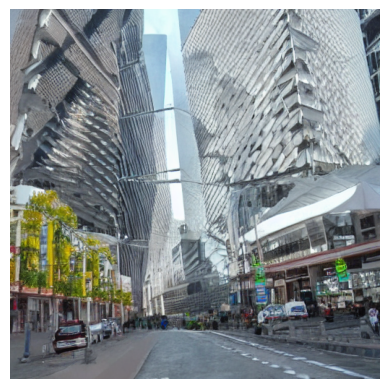

100%|██████████| 50/50 [00:41<00:00,  1.19it/s]


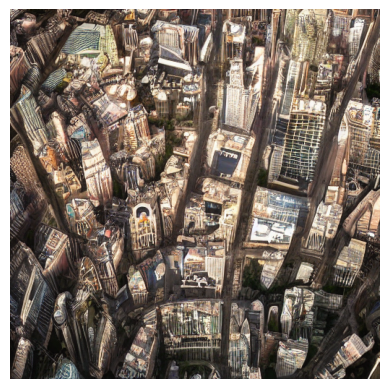

100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


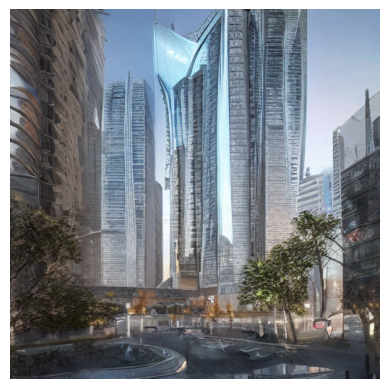

Key frames saved in outputs/keyframes


In [11]:
image_path = "images/test.jpg"  # Change this to your image path
text_prompt = "A city with a futuristic look."  # Change this to your text prompt
initial_image = preprocess_image(image_path)

generate_key_frames(initial_image, text_prompt, num_frames=3)